# Content-Based Recipe Recommendation

## The Recipe Dataset

### Data Preparation
Let's load this data into Python. I will load the dataset with Pandas onto Dataframes **ratings**, **users**, and **recipes**. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sys

import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import itertools

import random
import psutil
import os

Read datasets from CSV files.

In [2]:
# Reading ratings file
ratings = pd.read_csv('ratings.csv')

# Reading users file
users = pd.read_csv('users.csv')

# Reading recipes file. Then select attributes and generate the dataframe for calculation
recipes = pd.read_csv('allrecipes.csv')
recipes = recipes[['recipe_id', 'recipe_name', 'servings',
                      'group_name', 'calories','protein', 
                      'carbohydrates', 'fat', 'ingredients', 'recipe_source']]

## Data Exploration
### Ratings
I want to examine the **rating** further. Let's take a look at its summary statistics and distribution.

count    105.000000
mean       2.704762
std        1.386222
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: rating, dtype: float64


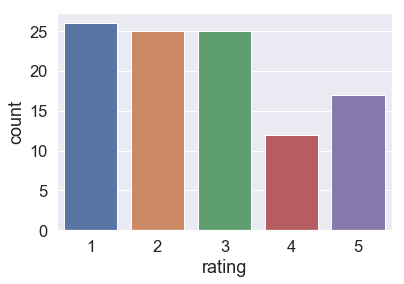

In [3]:
# Get summary statistics of rating
print(ratings['rating'].describe())

# Display distribution of rating
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline
sns.countplot(ratings['rating'])

### Genres
The genres variable will surely be important while building the recommendation engines since it describes the content of the recipe.

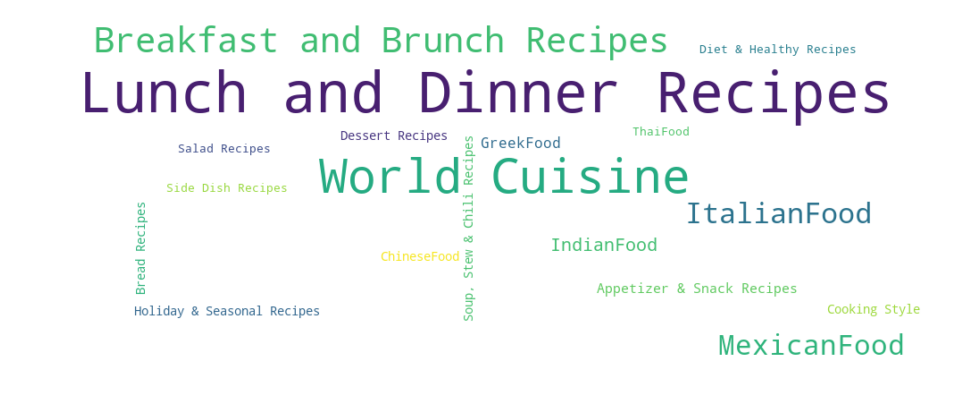

In [4]:
# Make a census of the group_name keywords
group_name_labels = set()
for s in recipes['group_name'].str.split('|').values:
    group_name_labels = group_name_labels.union(set(s))

# Function that counts the number of times each of the group_name keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1

    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of group_name keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(recipes, 'group_name', group_name_labels)
keyword_occurences[:5]

# Define the dictionary used to produce the genre wordcloud
group_names = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    group_names[s[0]] = s[1]

# Create the wordcloud
group_name_wordcloud = WordCloud(width=1000,height=400, background_color='white')
group_name_wordcloud.generate_from_frequencies(group_names)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(group_name_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Ingredients
The ingredients variable will be also important while building the recommendation engines because it significantly affect flavors.

In [5]:
pattern = re.compile(".+?'(.+?)'")
ingredients = np.zeros(recipes.shape[0])
ingredients = pd.Series(ingredients)
for i in range(recipes.shape[0]):
    temp = pattern.findall(recipes['ingredients'][i])
    temp = '|'.join(temp)
    ingredients[i] = temp
recipes['ingredients'] = ingredients

### Dataset
I merge recipes, ratings, and users to create a dataset.

In [6]:
# Join all 3 files into one dataframe
dataset = pd.merge(pd.merge(recipes, ratings),users)\

# Display 20 recipes with highest ratings
dataset[['recipe_name','group_name','rating','ingredients']].sort_values('rating', ascending=False).head(10)

,recipe_name,group_name,rating,ingredients
52,Slow Cooker Chicken and Dumplings,Slow Cooker Recipes|Chicken and Dumpling Recip...,5,"4 skinless, boneless chicken breast halves|2 t..."
85,Slow Cooker Creamy Chicken and Dumplings,"Soup, Stew & Chili Recipes|Chicken and Dumplin...",5,"4 skinless, boneless chicken breast halves|2 (..."
47,Herbed Dumplings,"Soup, Stew & Chili Recipes|Chicken and Dumplin...",5,1\u2009½ cups all-purpose flour|1 teaspoon sal...
48,Mom's Chicken and Dumplings (Slow Cooker Version),"Soup, Stew & Chili Recipes|Chicken and Dumplin...",5,4 (14.5 ounce) cans chicken broth|3 (12.5 fl o...
59,Chef John's Chicken and Dumplings,"Soup, Stew & Chili Recipes|Chicken and Dumplin...",5,1 (3 to 3 1/2 pound) whole chicken|2\u2009½ qu...
68,Super Easy Chicken and Dumplings,"Soup, Stew & Chili Recipes|Chicken and Dumplin...",5,2 (10.5 ounce) cans cream of chicken soup|3 (1...
78,Mom's Chicken and Dumplings (Slow Cooker Version),"Soup, Stew & Chili Recipes|Chicken and Dumplin...",5,4 (14.5 ounce) cans chicken broth|3 (12.5 fl o...
79,Better than Cracker Barrel® Chicken 'n Dumplings,"Soup, Stew & Chili Recipes|Chicken and Dumplin...",5,1 whole chicken|1 pinch salt|water to cover|1 ...
83,Super Easy Chicken and Dumplings,"Soup, Stew & Chili Recipes|Chicken and Dumplin...",5,2 (10.5 ounce) cans cream of chicken soup|3 (1...
82,Slow Cooker Chicken and Dumplings,Slow Cooker Recipes|Chicken and Dumpling Recip...,5,"4 skinless, boneless chicken breast halves|2 t..."


##  Content-Based Recommendation
The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it's easy to determine the context/properties of each item.

A content based recommender works with data that the user provides, either explicitly recipe ratings for the allrecipes dataset. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

### Theory
The concepts of **Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “**the results of latest European Socccer games**” on Google. It is certain that “**the**” will occur more frequently than “**soccer games**” but the relative importance of **soccer games** is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

Below is the equation to calculate the TF-IDF score:
<img src="images/tfidf.jpg" alt="tfidf" style="zoom:75%;" />

After calculating TF-IDF scores, how do we determine which items are closer to each other, rather closer to the user profile? This is accomplished using the **Vector Space Model** which computes the proximity based on the angle between the vectors. In this model, each item is stored as a vector of its attributes (which are also vectors) in an **n-dimensional space** and the angles between the vectors are calculated to **determine the similarity between the vectors**. Next, the user profile vectors are also created based on his actions on previous attributes of items and the similarity between an item and a user is also determined in a similar way.

<img src="images/vector_space.png" alt="vector-space" style="zoom:67%;" />

Sentence 2 is more likely to be using Term 2 than using Term 1. Vice-versa for Sentence 1. The method of calculating this relative measure is calculated by taking the cosine of the angle between the sentences and the terms. The ultimate reason behind using cosine is that the **value of cosine will increase with decreasing value of the angle** between which signifies more similarity. The vectors are length normalized after which they become vectors of length 1 and then the cosine calculation is simply the sum-product of vectors.

### Implementation (Most Similar Recipes)
With all that theory in mind, I am going to build a Content-Based Recommendation Engine that computes similarity between recipes based on recipe genres and ingredients. It will suggest recipes that are most similar to a particular recipe based on its genre. To do so, I will make use of the file **recipes.csv**.

In [7]:
# Break up the big string into a string array
feature = recipes['group_name'].str.split('|') + recipes['ingredients'].str.split('|')
print(feature.head())

# Convert to string value
feature = feature.fillna("").astype('str')

0    [Chicken Thigh Recipes, Soup, Stew & Chili Rec...
1    [Soup, Stew & Chili Recipes, Chicken and Dumpl...
2    [Soup, Stew & Chili Recipes, Chicken and Dumpl...
3    [Soup, Stew & Chili Recipes, Chicken and Dumpl...
4    [Soup, Stew & Chili Recipes, Chicken and Dumpl...
dtype: object


I do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively. In order to do so, I'll use **TfidfVectorizer** function from **scikit-learn**, which transforms text to feature vectors that can be used as input to estimator.

I will be using the **[Cosine Similarity](https://masongallo.github.io/machine/learning,/python/2016/07/29/cosine-similarity.html)** to calculate a numeric quantity that denotes the similarity between two recipes. Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's **linear_kernel** instead of cosine_similarities since it is much faster.

In [8]:
# Build a 1-dimensional array with recipe names
recipe_name = recipes['recipe_name']
recipe_source = recipes['recipe_source']
indices = pd.Series(recipes.index, index=recipes['recipe_name'])

In [9]:
def name_recommendations(name, allergy, num_sample, num_recipe):
    # The selected recipe
    idx = indices[name]
    recipe_id = range(len(feature))
    recipe_length = len(feature)
    sample_id = random.sample(recipe_id, num_sample)
    if idx not in sample_id:
        sample_id.append(idx)
        target = sample_id.index(idx)
    else:
        target = sample_id.index(idx)
    sample = feature.iloc[sample_id]
    sample_length = len(sample)
    name_feature = sample
    
    tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
    tfidf_matrix = tf.fit_transform(name_feature)
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    print(u'Memory usage of current process：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024))

    sim_scores = list(enumerate(cosine_sim[target]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(1+num_recipe)]
    recipe_indices = [name_feature.index[i[0]] for i in sim_scores]
    recipe_indices=list(filter(lambda x:x<=recipe_length, recipe_indices))    
    
    # Remove recieps that the user is allergic to
    user_allergy = allergy.split('|')
    removed_idx = []
    for i in recipe_indices:
        for j in range(len(user_allergy)):
            if user_allergy[j] in recipes['ingredients'][i]:
                print('The user is allergic to this recipe '+ recipe_name.iloc[i])
                removed_idx.append(i)
                break
    for i in range(len(removed_idx)):
        if removed_idx[i] in recipe_indices:
            recipe_indices.remove(removed_idx[i])
    return recipe_indices

Let's try and get the top recommendations for a few recipes and see how good the recommendations are.

In [10]:
name_recommendations('Chinese Five Spice Spare Ribs', 'peanut|sesame|lobster', 5000, 50)

Memory usage of current process：0.5516 GB
The user is allergic to this recipe Instant Pot® Asian-Style Pulled Pork
The user is allergic to this recipe Asian Salmon Patties
The user is allergic to this recipe Kalbi Ribs
The user is allergic to this recipe Tasty Sesame Tilapia
The user is allergic to this recipe Honey-Glazed Baked Salmon
The user is allergic to this recipe Chinese Restaurant-Style Sesame Chicken
The user is allergic to this recipe Amber's Sesame Chicken
The user is allergic to this recipe Kai's Chicken Potstickers
The user is allergic to this recipe Thai-Style Peanut Sauce
The user is allergic to this recipe Chinese Mabo Tofu
The user is allergic to this recipe Filipino Steamed Rice, Cebu Style
The user is allergic to this recipe General Tso's Chicken
The user is allergic to this recipe Addictive Sesame Chicken
The user is allergic to this recipe Taiwanese Fried Tofu
The user is allergic to this recipe Easy Moo Shu Pork
The user is allergic to this recipe Sesame Grilled 

[4396,
 21506,
 632,
 20727,
 25235,
 21583,
 25201,
 2762,
 22088,
 22173,
 20602,
 24748,
 20225,
 1565,
 20247,
 1377,
 4667,
 25580]

### Implementation (Favourite Features)

The user will select their favourite features and the model will return recipes correspoding to those features.

In [11]:
def feature_recommendations(like, allergy, num_sample, num_recipe):
    # User's favourite feature
    recipe_id = range(len(feature))
    recipe_length = len(feature)
    sample_id = random.sample(recipe_id, num_sample)
    sample = feature.iloc[sample_id]
    sample_length = len(sample)
    user_like_feature = sample
    temps = like.split('|')

    real_length = len(feature)
    for i in range(len(temps)):
        user_like = pd.Series(str(temps[i].split('&&')))
        user_like_feature[recipe_length + i] = user_like[0]
        real_length = real_length + 1

    # Convert to string value
    user_like_feature_str = user_like_feature.fillna("").astype('str')
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
    user_like_tfidf_matrix = tf.fit_transform(user_like_feature_str)
    print(u'Memory usage of current process：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024))
    user_like_cosine_sim = linear_kernel(user_like_tfidf_matrix, user_like_tfidf_matrix)

    # The index of user_like vector
    union = []
    for i in range(len(temps)):
        idx = len(user_like_feature) - (i + 1)
        sim_scores = list(enumerate(user_like_cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:(1+num_recipe)]
        recipe_indices = [user_like_feature.index[i[0]] for i in sim_scores]
        recipe_indices=list(filter(lambda x:x<=recipe_length, recipe_indices))

        # Remove recieps that the user is allergic to
        user_allergy = allergy.split('|')
        removed_idx = []
        for i in recipe_indices:
            for j in range(len(user_allergy)):
                if user_allergy[j] in recipes['ingredients'][i]:
                    print('The user is allergic to this recipe ' + recipe_name.iloc[i])
                    removed_idx.append(i)
                    break
        for i in range(len(removed_idx)):
            if removed_idx[i] in recipe_indices:
                recipe_indices.remove(removed_idx[i])
        union.append(recipe_indices)
    return union

In [12]:
user_like = 'ice cream | (salty && Chinese)'
user_allergy = 'peanut|sesame|lobster'
num_sample = 5000
num_recipe = 50
union = feature_recommendations(user_like, user_allergy, num_sample, num_recipe)
union

Memory usage of current process：0.1806 GB
The user is allergic to this recipe Congee
The user is allergic to this recipe Fiery Pepper Chicken
The user is allergic to this recipe Taiwanese Fried Tofu
The user is allergic to this recipe Asian Salmon Patties
The user is allergic to this recipe Korean BBQ-Inspired Short Ribs
The user is allergic to this recipe Ahi Tuna Spice Rub
The user is allergic to this recipe Chinese Restaurant-Style Sesame Chicken
The user is allergic to this recipe Hiyashi Chuka Noodles
The user is allergic to this recipe Grilled Hoisin Beef
The user is allergic to this recipe Kai's Chicken Potstickers
The user is allergic to this recipe Popcorn Chicken (Taiwanese)
The user is allergic to this recipe Chinese New Year Sweet Rice
The user is allergic to this recipe Chinese Clay Pot Chicken Rice
The user is allergic to this recipe Mu Shu Pork
The user is allergic to this recipe Homemade Peanut Butter Ice Cream
The user is allergic to this recipe Strawberry-Banana-Peanu

[[4419,
  21581,
  2955,
  4440,
  19903,
  4360,
  5641,
  4332,
  21318,
  24898,
  4339,
  13035,
  14048,
  16582,
  13218,
  5012,
  13809,
  13155,
  8192,
  8825,
  5283,
  3465,
  16047,
  14184,
  15214,
  1716,
  5396,
  17650,
  8432,
  24696,
  14501,
  12412,
  7580,
  15904,
  3826,
  12350],
 [2791,
  2795,
  2803,
  2787,
  2789,
  16222,
  2788,
  7716,
  2782,
  15374,
  12768,
  11564,
  2785,
  2211,
  14556,
  4933,
  4614,
  15544,
  16459,
  1861,
  3845,
  13068,
  14376,
  1851,
  4924,
  16213,
  15705,
  8890,
  14661,
  15075,
  5781,
  15345,
  14429,
  1783,
  3844,
  4197,
  2590,
  15264,
  15677,
  23275,
  14852,
  7461,
  14161,
  16054,
  13433,
  7668]]

### Implementation (User's Profile)

Based on user's previous decisions (e.g. selected recieps, favourite features) and the user's general setting, we can create a user' profile vector to recommend recipes if user do not have any settings at first.

Basically this part is the combination of most similar recipes and favourite features.
- Based on user's recent recipe choice:
    1. Because you chose Beefy Chinese Dumplings: recommmend some similar recipes.
    2. Because you chose Italian Stuffed Chicken Breast: recommmend some similar recipes.
    3. Because you chose ...
- Based on user's favourite features: 
    1. Because you searched Chinese and eggs: recommmend recipes
    2. Because you searched Italian and cheese: recommend recipes